In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [2]:
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rcParams['axes.linewidth'] = 0.5

plt.rcParams["figure.dpi"] = 300

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

perc_axes = 0.07409181787428054


In [3]:
def plot_curves(filename, samples):
    """
    Plot the curves from standard format plate reader data with error.
    This function assumes there are DMSO and radicicol conditions each
    done in triplicate.
    
    Args:
        filename: str; path of plate reader data
        samples: list; sample names in order loaded into plate
    Returns:
        
    """
    
    # Read in the datafile
    raw = pd.read_csv(filename, delimiter='\t', index_col=0)
    
    # Define rows and columns
    rows = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
    cols = np.arange(1, 13)

    # Define order of conditions left to right
    conditions = ['DMSO', 'radicicol']

    # Define sample names and order
    sample = samples

    # Define the number of wells that correspond to each sample
    wellsPerSample = 6
    sampleCount = len(sample)

    # Initialize empty lists 
    colLabels = []
    wellID = []
    sampleLabels = []

    # Label wells to [condition]_[sample]
    row = 0
    col = wellsPerSample
    for idx in np.arange(sampleCount):
        if row > (wellsPerSample + 1):
            row = row % wellsPerSample - 2
            col = col + wellsPerSample
        colLabels = colLabels + [rows[row] + str(i) for i in np.arange(col - (wellsPerSample - 1), col + 1)]
        row += 1

        sampleLabels = sampleLabels + [conditions[0] + '_' + str(idx) for num in np.arange(1, 4)]
        sampleLabels = sampleLabels + [conditions[1] + '_' + str(idx) for num in np.arange(1, 4)]
    raw.rename(dict(zip(colLabels, sampleLabels)), axis = 1, inplace = True)

    # Drop columns that are not used in the assay
    idx = ['_' not in name for name in raw.columns]
    raw.drop(raw.columns[idx][2:], axis = 1, inplace = True)

    # Create an minutes column that is separate from the index (used later for plotting)
    raw['minutes'] = raw.index * 30 + 30
    
    # Convert to long data format
    long_dat = pd.wide_to_long(raw, stubnames=conditions, i='minutes', j='sample', sep='_')

    # Swap levels for indexing
    long_dat['minutes'] = long_dat.index.get_level_values(0)
    long_dat['sample'] = long_dat.index.get_level_values(1)
    long_dat = long_dat.swaplevel(i=1, j=0, axis=0)
    
    # Plot curves for each sample present in experiment
    # Get sample index via name
    for sample_name in sample:
        idx = sample.index(sample_name)

        # Plot both DMSO and radicicol conditions
        sns.lineplot(x='minutes', y='DMSO', data=long_dat.loc[idx], ci='sd')
        sns.lineplot(x='minutes', y='radicicol', data=long_dat.loc[idx], ci='sd')
        plt.legend(['DMSO', 'radicicol'])
        plt.title(sample_name)
        plt.show()

In [4]:
def plot_grs(filename, samples):
    growth_rates = pd.read_csv(filename, index_col='Well', delimiter='\t', skiprows=1)
    
    wells_per_sample = 6

    # Define well dictionary where key=sample, value=wells
    well_dict = {}
    for idx, sample in enumerate(samples):

        # Get row number and convert to letter
        row_idx = idx % 8
        row_char = chr(ord('@') + row_idx + 1)  # + 1 b/c it is indexed at 1

        # Determine if it's cols 1-6 or 7-12
        if idx / 8 >= 1.0:
            cols = np.arange(7, 13)
        else:
            cols = np.arange(1, 7)

        # Create dictionary where key=sample, value=wells
        well_dict[sample] = [row_char + str(col_idx) for col_idx in cols]
        
    # Add sample_id and condition columns
    growth_rates['sample_id'] = np.nan
    growth_rates['condition'] = np.nan
    for sample, wells in well_dict.items():
        dmso_wells = wells[:int(wells_per_sample / 2)]
        rad_wells = wells[int(wells_per_sample / 2):]
        growth_rates.loc[wells, 'sample_id'] = sample
        growth_rates.loc[dmso_wells, 'condition'] = 'DMSO'
        growth_rates.loc[rad_wells, 'condition'] = 'Radicicol'

    growth_rates.dropna(inplace=True)
    
    sns.barplot(x='sample_id', y='Rate', hue='condition', data=growth_rates)
    plt.show()
    return(growth_rates)

In [5]:
filename = '../raw_data/20201120_edward_ihb_formatted.summary'

growth_rates = pd.read_csv(filename, index_col='Well', delimiter='\t', skiprows=1)

In [6]:
filename = '/Users/vanessanguyen/fowler/src/raw_data/Validation/20201201/20201201_formatted_fixed_well.summary'
filename = '../raw_data/20201201_formatted_fixed_well.summary'
samples = ['WT', 'Empty', 'K298M', 'E381K', 'E335M', 'V274N', 'R294T', 'F512P']
growth_rates = pd.read_csv(filename, index_col='Well', delimiter='\t', skiprows=1)

wells_per_sample = 6

# Define well dictionary where key=sample, value=wells
well_dict = {}
for idx, sample in enumerate(samples):

    # Get row number and convert to letter
    row_idx = idx % 8
    row_char = chr(ord('@') + row_idx + 1)  # + 1 b/c it is indexed at 1

    # Determine if it's cols 1-6 or 7-12
    if idx / 8 >= 1.0:
        cols = np.arange(7, 13)
    else:
        cols = np.arange(1, 7)

    # Create dictionary where key=sample, value=wells
    well_dict[sample] = [row_char + str(col_idx) for col_idx in cols]

# Add sample_id and condition columns
growth_rates['sample_id'] = np.nan
growth_rates['condition'] = np.nan
for sample, wells in well_dict.items():
    dmso_wells = wells[:int(wells_per_sample / 2)]
    rad_wells = wells[int(wells_per_sample / 2):]
    growth_rates.loc[wells, 'sample_id'] = sample
    growth_rates.loc[dmso_wells, 'condition'] = 'DMSO'
    growth_rates.loc[rad_wells, 'condition'] = 'Radicicol'

growth_rates.dropna(inplace=True)

wt_dmso = growth_rates[(growth_rates['sample_id'] == 'WT') & (growth_rates['condition'] == 'DMSO')]['Rate'].values
wt_rad = growth_rates[(growth_rates['sample_id'] == 'WT') & (growth_rates['condition'] == 'Radicicol')]['Rate'].values
e381k_dmso = growth_rates[(growth_rates['sample_id'] == 'E381K') & (growth_rates['condition'] == 'DMSO')]['Rate'].values
e381k_rad = growth_rates[(growth_rates['sample_id'] == 'E381K') & (growth_rates['condition'] == 'Radicicol')]['Rate'].values

dmso_grs = [np.mean(wt_dmso), np.mean(e381k_dmso)]
rad_grs = [np.mean(wt_rad), np.mean(e381k_rad)]

dmso_stds = [np.std(wt_dmso), np.std(e381k_dmso)]
rad_stds = [np.std(wt_rad), np.std(e381k_rad)]


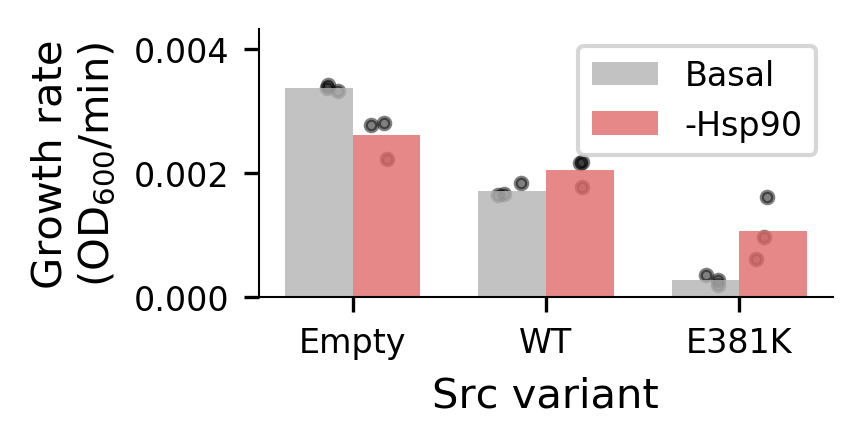

In [7]:
wt_dmso = growth_rates[(growth_rates['sample_id'] == 'WT') & (growth_rates['condition'] == 'DMSO')]['Rate'].values
wt_rad = growth_rates[(growth_rates['sample_id'] == 'WT') & (growth_rates['condition'] == 'Radicicol')]['Rate'].values
e381k_dmso = growth_rates[(growth_rates['sample_id'] == 'E381K') & (growth_rates['condition'] == 'DMSO')]['Rate'].values
e381k_rad = growth_rates[(growth_rates['sample_id'] == 'E381K') & (growth_rates['condition'] == 'Radicicol')]['Rate'].values
empty_dmso = growth_rates[(growth_rates['sample_id'] == 'Empty') & (growth_rates['condition'] == 'DMSO')]['Rate'].values
empty_rad = growth_rates[(growth_rates['sample_id'] == 'Empty') & (growth_rates['condition'] == 'Radicicol')]['Rate'].values


dmso_grs = [np.mean(wt_dmso), np.mean(e381k_dmso), np.mean(empty_dmso)]
rad_grs = [np.mean(wt_rad), np.mean(e381k_rad), np.mean (empty_rad)]

dmso_stds = [np.std(wt_dmso), np.std(e381k_dmso), np.std(empty_dmso)]
rad_stds = [np.std(wt_rad), np.std(e381k_rad), np.std(empty_rad)]

# Rearrange lists
my_order = [2, 0, 1]
dmso_grs = [dmso_grs[i] for i in my_order]
rad_grs = [rad_grs[i] for i in my_order]
dmso_stds = [dmso_stds[i] for i in my_order]
rad_stds = [rad_stds[i] for i in my_order]

bar_pos = np.arange(len(dmso_grs))
bar_width = 0.35

fig, ax = plt.subplots(figsize=(2.76, 1.373), constrained_layout=True)
ax.bar(bar_pos - bar_width / 2, dmso_grs, width=bar_width, color='#b3b3b3', label='Basal', alpha=0.8)
ax.bar(bar_pos + bar_width / 2, rad_grs, width=bar_width, color='#e26a6a', label='-Hsp90', alpha=0.8)

# Section for jittering the dots
n = len(dmso_grs)
x_jitter_pos = np.array([bar_pos] * n)
row, col = x_jitter_pos.shape
rand_arr = (np.random.rand(row, col) - 0.5) / 5
rand_arr_2 = (np.random.rand(row, col) - 0.5) / 5

y_arr_dmso = np.array((empty_dmso, wt_dmso, e381k_dmso)).T
y_arr_rad = np.array((empty_rad, wt_rad, e381k_rad)).T

ax.scatter((bar_pos - bar_width / 2) + rand_arr, y_arr_dmso, c='k', s=7.5, alpha=0.5)
ax.scatter((bar_pos + bar_width / 2) + rand_arr_2, y_arr_rad, c='k', s=7.5, alpha=0.5)

ax.legend()
ymin, ymax = ax.get_ylim()
ax.set_ylim(ymin, ymax + 0.2 * ymax)
ax.set_xlabel('Src variant')
ax.set_ylabel('Growth rate\n(OD$_{600}$/min)')
#ax.set_yticks([0.0,0.001,0.002])
#ax.set_yticklabels(ax.get_yticks())
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['Empty', 'WT', 'E381K', ])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.savefig('f1.png')